#### Project Overview

This is the first Captone project for SpringBoard using the UCI dataset: Diabetes 130-US hospitals for years 1999-2008 Data Set. Detailed description of the dataset can be found here - https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008.

### Step One - Data Wrangling
First step is to read in the CSV file and explore the data to check for:
1) non-numerical values
2) missing cells

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
df_raw=pd.read_csv('/Users/YingShen/Desktop/Data_Science/SpringBorad/Git/dataset_diabetes/diabetic_data.csv')

#### I. Preliminary Analysis
First roughly explore the data to see if there are too many missing cells.

In [18]:
print(df_raw.shape)
df_raw.head()
# there are missing values coded as "?"; and many medications were not prescribed

(101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [19]:
df_raw.isin(["?","No","Unknown/Invalid","None"]).sum()

encounter_id                     0
patient_nbr                      0
race                          2273
gender                           3
age                              0
weight                       98569
admission_type_id                0
discharge_disposition_id         0
admission_source_id              0
time_in_hospital                 0
payer_code                   40256
medical_specialty            49949
num_lab_procedures               0
num_procedures                   0
num_medications                  0
number_outpatient                0
number_emergency                 0
number_inpatient                 0
diag_1                          21
diag_2                         358
diag_3                        1423
number_diagnoses                 0
max_glu_serum                96420
A1Cresult                    84748
metformin                    81778
repaglinide                 100227
nateglinide                 101063
chlorpropamide              101680
glimepiride         

#### Exclude missing observations
As shown aove, some features have too many missingness, including:

weight: 98569 missing;
payer_code: 40256 missing;
medical_specialty: 49949 missing

Medical_specialty will be kept; other two variables are considered not relevent to the outcome and will be dropped; Medicatoins will be processed to include information about whether there is a increase in dosage, a dicrease in dosage, or no change in dosage.

In [20]:
# Select the features we need to process
df=df_raw.drop(columns=['weight','payer_code'])

# Same patienets are highly correlated with themselves and should be dropped
df.drop_duplicates(subset=["patient_nbr"],inplace=True) 
df.drop(columns=['encounter_id','patient_nbr'],inplace=True)

# There are 3 invalid/unknown cells in gender; just delete them
df=df[df_raw['gender']!="Unknown/Invalid"]

# Drop encounters that ended in deaths or hospice
df3=df[df['discharge_disposition_id'].isin([11,13,14,19,20,21])==False]

''' Get a general idea of the variables left'''
print(df3.shape) 

'''Then explore numeric variables in the dataset'''
print(df.describe().loc[['mean','min','max']])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


(69970, 46)
      admission_type_id  discharge_disposition_id  admission_source_id  \
mean           2.100273                   3.59305             5.657484   
min            1.000000                   1.00000             1.000000   
max            8.000000                  28.00000            25.000000   

      time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
mean           4.28917           43.075858        1.430525        15.704999   
min            1.00000            1.000000        0.000000         1.000000   
max           14.00000          132.000000        6.000000        81.000000   

      number_outpatient  number_emergency  number_inpatient  number_diagnoses  
mean           0.280081          0.103545          0.177837          7.245753  
min            0.000000          0.000000          0.000000          1.000000  
max           42.000000         42.000000         12.000000         16.000000  


In [21]:
df.isin(["?","No","Unknown/Invalid","None"]).sum()
''' Medications to keep: 'metformin','glipizide','glyburide','insulin' '''

" Medications to keep: 'metformin','glipizide','glyburide','insulin' "

In [22]:
''' Explore categorical variables in the dataset'''
cat_l=['race', 'gender', 'age','max_glu_serum', 'A1Cresult','change', 
       'diabetesMed', 'readmitted'] # 'medical_specialty', 'diag_1'-'diag_3'

for i in cat_l:
    print(i+':\n')
    print(df[i].value_counts())

race:

Caucasian          53491
AfricanAmerican    12887
?                   1946
Hispanic            1517
Other               1177
Asian                497
Name: race, dtype: int64
gender:

Female    38025
Male      33490
Name: gender, dtype: int64
age:

[70-80)     18208
[60-70)     15959
[50-60)     12466
[80-90)     11589
[40-50)      6878
[30-40)      2699
[90-100)     1900
[20-30)      1127
[10-20)       535
[0-10)        154
Name: age, dtype: int64
max_glu_serum:

None    68059
Norm     1731
>200      969
>300      756
Name: max_glu_serum, dtype: int64
A1Cresult:

None    58529
>8       6304
Norm     3791
>7       2891
Name: A1Cresult, dtype: int64
change:

No    39493
Ch    32022
Name: change, dtype: int64
diabetesMed:

Yes    54317
No     17198
Name: diabetesMed, dtype: int64
readmitted:

NO     42982
>30    22240
<30     6293
Name: readmitted, dtype: int64


In [23]:
''' Transform target variable to be 1 versus 0 '''
df['readmitted_d']=df['readmitted'].apply(lambda x: 1 if x=="<30" else 0)

#### Some numerical variables actually have categorical meanings: 
#### 1. discharge_disposition_id:  indicates discharge status
patients who were discharged dead were excluded from the study; then, we will create a new variable based on the readmition rates

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


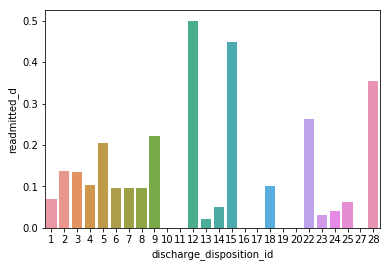

In [24]:
''' Create a reusable function to generate barplots for categorical variables '''
def category_barplot(feature,target,df):
    f=df.groupby([feature])[target].mean()
    feature_df=pd.DataFrame(f)
    feature_df=feature_df.reset_index()
    g=sns.barplot(x=feature,y=target,data=feature_df)
    return plt.show()

category_barplot('discharge_disposition_id','readmitted_d',df)

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


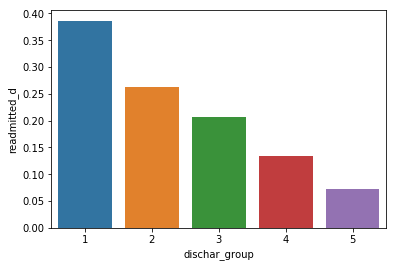

In [25]:
def dicharge_group(value):
    if value in (12,15,28):
        return 1
    if value ==22:
        return 2
    if value in (5,9):
        return 3
    if value in (2,3):
        return 4
    else:
        return 5
df['dischar_group']=df['discharge_disposition_id'].apply(dicharge_group)
category_barplot('dischar_group','readmitted_d',df)

#### 2. admission_source_id:  indicates admission type

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


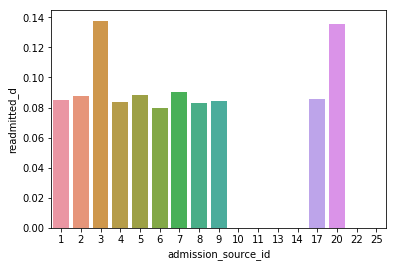

In [26]:
category_barplot('admission_source_id','readmitted_d',df)

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


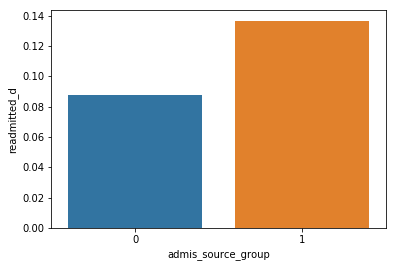

In [27]:
def ad_cource_group(value):
    if value==3 or value==20:
        return 1
    else: 
        return 0
df['admis_source_group']=df['admission_source_id'].apply(ad_cource_group)
category_barplot('admis_source_group','readmitted_d',df)

#### 3.　admission_type_id: indicates emergent of elective

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


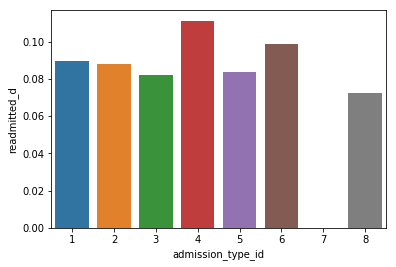

In [28]:
category_barplot('admission_type_id','readmitted_d',df)

In [29]:
def ad_type_group(value):
    if value==4 or value==6:
        return 1
    else: 
        return 0
df['ad_type_group']=df['admission_type_id'].apply(ad_type_group)
# category_barplot('ad_type_group','readmitted_d',df)

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


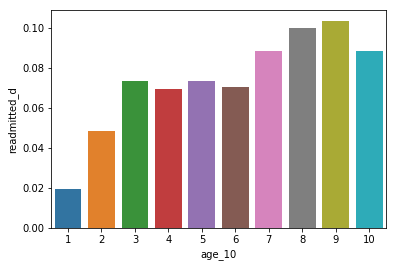

In [30]:
''' Transform age category into norminal variables '''
age_dict={"[0-10)":1,"[10-20)":2,"[20-30)":3,"[30-40)":4,"[40-50)":5,"[50-60)":6,
          "[60-70)":7,"[70-80)":8,"[80-90)":9,"[90-100)":10}
df["age_10"]=df["age"].map(age_dict)
category_barplot('age_10','readmitted_d',df)

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


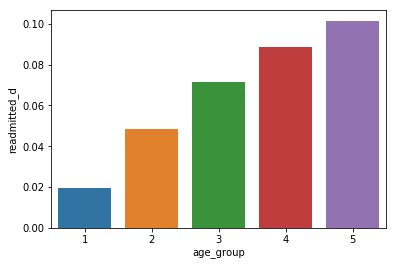

In [31]:
def age_group(value):
    if value==1:
        return 1
    if value==2:
        return 2
    if value in (3,4,5,6):
        return 3
    if value in (7,10):
        return 4
    else: 
        return 5
df['age_group']=df['age_10'].apply(age_group)
category_barplot('age_group','readmitted_d',df)

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


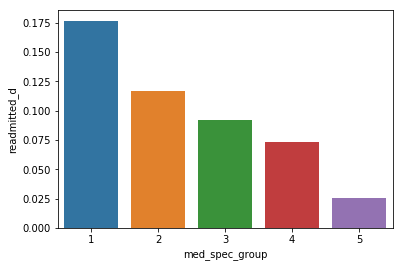

In [32]:
''' group codes about the physician specialty '''
series=df.groupby(['medical_specialty'])['readmitted_d'].mean()
ranked=series.sort_values(ascending=False)
rank_1=[]
rank_2=[]
rank_3=[]
rank_4=[]
rank_5=[]
for i in ranked.index:
    if ranked[i]>=0.15:
        rank_1.append(i)
    if 0.15>ranked[i]>=0.11:
        rank_2.append(i)
    if 0.11>ranked[i]>=0.09:
        rank_3.append(i)
    if 0.09>ranked[i]>=0.05:
        rank_4.append(i)
    if 0.05>ranked[i]:
        rank_5.append(i)
        
def med_spec_group(string):
    if string in rank_1:
        return 1
    if string in rank_2:
        return 2
    if string in rank_3:
        return 3
    if string in rank_4:
        return 4
    if string in rank_5:
        return 5
    else:
        return 6
df['med_spec_group']=df['medical_specialty'].apply(med_spec_group)
category_barplot('med_spec_group','readmitted_d',df)

####  Transform other categorical variables into dummy variables

In [33]:
df["gender_d"]=df["gender"].apply(lambda x: 1 if x=="Male" else 0) 
df['max_glu_dummy']=df['max_glu_serum'].apply(lambda x: 0 if x=="None" else 1)
df['A1Cresult_dummy']=df['A1Cresult'].apply(lambda x: 0 if x=="None" else 1)
df['change_d']=df['change'].apply(lambda x: 1 if x=="Ch" else 0)
df['diabetesMed_d']=df['diabetesMed'].apply(lambda x: 1 if x=="Yes" else 0)

#### Based on the features I have, it is necessary to create new features that are potential to be related with the outcome

In [34]:
temp_AlC8=pd.get_dummies(df['A1Cresult']).loc[:,'>8']
temp_None=pd.get_dummies(df['A1Cresult']).loc[:,'None']

temp_ch=pd.get_dummies(df['change']).loc[:,'Ch']
temp_no=pd.get_dummies(df['change']).loc[:,'No']

temp_AlC8_Changed=temp_AlC8*temp_ch
temp_AlC8_NonCh=temp_AlC8*temp_no

df['No_Alc']=temp_None
df['Alc_ch']=temp_AlC8_Changed
df['Alc_nonch']=temp_AlC8_NonCh

In [35]:
''' Add new information about whether the drugs were up or down '''

drugs_df=df[['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']]
up_df=drugs_df.isin(['Up'])
down_df=drugs_df.isin(['Down'])
df['med_up']=up_df.sum(axis=1)
df['med_down']=down_df.sum(axis=1)

In [36]:
df['med_down'].value_counts()

0    62639
1     8680
2      192
3        4
Name: med_down, dtype: int64

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


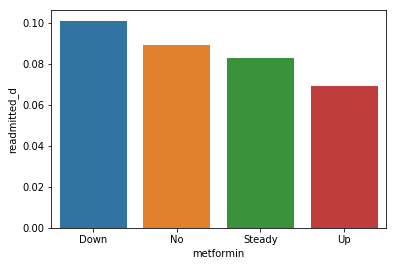

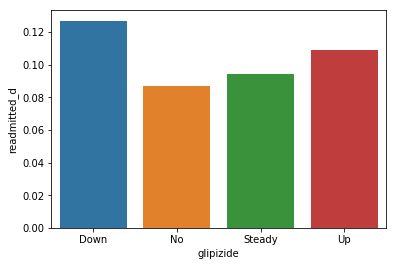

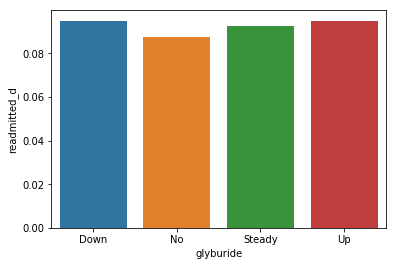

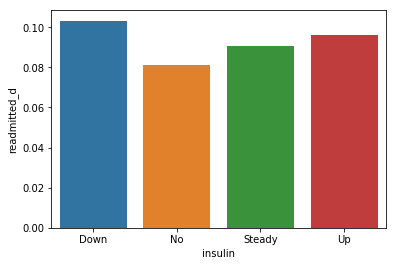

In [37]:
med_list=['metformin','glipizide','glyburide','insulin']

category_barplot('metformin','readmitted_d',df)
category_barplot('glipizide','readmitted_d',df)
category_barplot('glyburide','readmitted_d',df) # will drop
category_barplot('insulin','readmitted_d',df)

In [38]:
df.drop(columns=['repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone'],inplace=True)

#### Charlson Comorbidity Score from ICD-9-CM diagnosis codes
Diagnosis codes are useful to indicate the severity of illness a patient has, which is a common way of adjusting health conditions of a patient in academia

In [39]:
series_count=pd.DataFrame(df['diag_1'].value_counts())
series_rates=pd.DataFrame(df.groupby(['diag_1'])['readmitted_d'].mean())

temp_df=series_count.merge(series_rates,left_index=True,right_index=True)
temp_df1=temp_df[temp_df['readmitted_d']>0.15]
diag_1st=temp_df1.index.tolist()

temp_df2=temp_df[temp_df['readmitted_d']>0.1]
diag_2nd=set(temp_df2.index.tolist())-set(diag_1st)

temp_df3=temp_df[temp_df['readmitted_d']>0.05]
diag_3rd=set(temp_df3.index.tolist())-set(diag_1st)-set(diag_2nd)

# temp_df4=temp_df[temp_df['readmitted_d']<=0.05]
# diag_4th=set(temp_df4.index.tolist())

def diag_group(string):
    if string in diag_1st:
        return 1
    if string in diag_2nd:
        return 2
    if string in diag_3rd:
        return 3
    else:
        return 4
df['diag_group']=df['diag_1'].apply(diag_group)

In [40]:
''' Transform diagnosis codes into meaningful CCI scores using regular expression '''
# Diagnosis 1
df["MI_CHF_Cereb_Dem_1"]=df['diag_1'].str.match(r'(41[02][.]?\d?\d?)|(428[.]?\d?\d?)|(43[0-8][.]?\d?\d?)|(290[.]?\d?\d?)')
df["PVF_1"]=df['diag_1'].str.match(r'(443[.]9\d?)|(441[.]?\d?\d?)|(785[.]4\d?)|(V43[.]4\d?)')
df["ChroPul_1"]=df['diag_1'].str.match(r'((49[0-9])|(50[0-5])[.]?\d?\d?)|(506.4\d?)')
df["Rheu_1"]=df['diag_1'].str.match(r'(710[.][014]])|(714[.][02])|(714[.]81)|(724[.]?\d?\d?)')
df["PepUlc_Liver_Diabetes_1"]=df['diag_1'].str.match(r'(53[1-4][.]?\d?\d?)|(571[.][2456]\d?)|(250[.][01237]\d?)')
df["Hemip_Diabetes_1"]=df['diag_1'].str.match(r'(250[.][456]\d?)|(344[.]1\d?)|(342[.]?\d?\d?)|(250)')
df["Renal_1"]=df['diag_1'].str.match(r'58[23568][.]?\d?\d?')
df["Cancer_1"]=df['diag_1'].str.match(r'(1[4-6][0-9][.]?\d?\d?)|(17[0-2][.]?\d?\d?)|(17[4-9][.]?\d?\d?)|\
                                      (18[0-9][.]?\d?\d?)|(195[.]8)|(20[0-8][.]?\d?\d?)')          
df["Liver_1"]=df['diag_1'].str.match(r'(456[.][01][0-9]?)|(456[.]2[01])|(572[.][2-8]\d?)')
df["Metas_1"]=df['diag_1'].str.match(r'(19[6-8][.]?\d?\d?)|(199[.]1)')
df["HIV_1"]=df['diag_1'].str.match(r'04[2-4][.]?\d?\d?')

# Diagnosis 2
df["MI_CHF_Cereb_Dem_2"]=df['diag_2'].str.match(r'(41[02][.]?\d?\d?)|(428[.]?\d?\d?)|(43[0-8][.]?\d?\d?)|(290[.]?\d?\d?)')
df["PVF_2"]=df['diag_2'].str.match(r'(443[.]9\d?)|(441[.]?\d?\d?)|(785[.]4\d?)|(V43[.]4\d?)')
df["ChroPul_2"]=df['diag_2'].str.match(r'((49[0-9])|(50[0-5])[.]?\d?\d?)|(506.4\d?)')
df["Rheu_2"]=df['diag_2'].str.match(r'(710[.][014]])|(714[.][02])|(714[.]81)|(724[.]?\d?\d?)')
df["PepUlc_Liver_Diabetes_2"]=df['diag_2'].str.match(r'(53[1-4][.]?\d?\d?)|(571[.][2456]\d?)|(250[.][01237]\d?)')
df["Hemip_Diabetes_2"]=df['diag_2'].str.match(r'(250[.][456]\d?)|(344[.]1\d?)|(342[.]?\d?\d?)|(250)')
df["Renal_2"]=df['diag_2'].str.match(r'58[23568][.]?\d?\d?')
df["Cancer_2"]=df['diag_2'].str.match(r'(1[4-6][0-9][.]?\d?\d?)|(17[0-2][.]?\d?\d?)|(17[4-9][.]?\d?\d?)|\
                                      (18[0-9][.]?\d?\d?)|(195[.]8)|(20[0-8][.]?\d?\d?)')          
df["Liver_2"]=df['diag_2'].str.match(r'(456[.][01][0-9]?)|(456[.]2[01])|(572[.][2-8]\d?)')
df["Metas_2"]=df['diag_2'].str.match(r'(19[6-8][.]?\d?\d?)|(199[.]1)')
df["HIV_2"]=df['diag_2'].str.match(r'04[2-4][.]?\d?\d?')

# Diagnosis 3
df["MI_CHF_Cereb_Dem_3"]=df['diag_3'].str.match(r'(41[02][.]?\d?\d?)|(428[.]?\d?\d?)|(43[0-8][.]?\d?\d?)|(290[.]?\d?\d?)')
df["PVF_3"]=df['diag_3'].str.match(r'(443[.]9\d?)|(441[.]?\d?\d?)|(785[.]4\d?)|(V43[.]4\d?)')
df["ChroPul_3"]=df['diag_3'].str.match(r'((49[0-9])|(50[0-5])[.]?\d?\d?)|(506.4\d?)')
df["Rheu_3"]=df['diag_3'].str.match(r'(710[.][014]])|(714[.][02])|(714[.]81)|(724[.]?\d?\d?)')
df["PepUlc_Liver_Diabetes_3"]=df['diag_3'].str.match(r'(53[1-4][.]?\d?\d?)|(571[.][2456]\d?)|(250[.][01237]\d?)')
df["Hemip_Diabetes_3"]=df['diag_3'].str.match(r'(250[.][456]\d?)|(344[.]1\d?)|(342[.]?\d?\d?)|(250)')
df["Renal_3"]=df['diag_3'].str.match(r'58[23568][.]?\d?\d?')
df["Cancer_3"]=df['diag_3'].str.match(r'(1[4-6][0-9][.]?\d?\d?)|(17[0-2][.]?\d?\d?)|(17[4-9][.]?\d?\d?)|\
                                      (18[0-9][.]?\d?\d?)|(195[.]8)|(20[0-8][.]?\d?\d?)')          
df["Liver_3"]=df['diag_3'].str.match(r'(456[.][01][0-9]?)|(456[.]2[01])|(572[.][2-8]\d?)')
df["Metas_3"]=df['diag_3'].str.match(r'(19[6-8][.]?\d?\d?)|(199[.]1)')
df["HIV_3"]=df['diag_3'].str.match(r'04[2-4][.]?\d?\d?')

In [41]:
df['Score_1']=(df['MI_CHF_Cereb_Dem_1']+df["PVF_1"]+df["ChroPul_1"]+df["Rheu_1"]+df["PepUlc_Liver_Diabetes_1"])*1+\
            (df["Hemip_Diabetes_1"]+df["Renal_1"]+df["Cancer_1"])*2+(df["Liver_1"])*3+(df["Metas_1"]+df["HIV_1"])*6

df['Score_2']=(df['MI_CHF_Cereb_Dem_2']+df["PVF_2"]+df["ChroPul_2"]+df["Rheu_2"]+df["PepUlc_Liver_Diabetes_2"])*1+\
            (df["Hemip_Diabetes_2"]+df["Renal_2"]+df["Cancer_2"])*2+(df["Liver_2"])*3+(df["Metas_2"]+df["HIV_2"])*6

df['Score_3']=(df['MI_CHF_Cereb_Dem_3']+df["PVF_3"]+df["ChroPul_3"]+df["Rheu_3"]+df["PepUlc_Liver_Diabetes_3"])*1+\
            (df["Hemip_Diabetes_3"]+df["Renal_3"]+df["Cancer_3"])*2+(df["Liver_3"])*3+(df["Metas_3"]+df["HIV_3"])*6
df['CCI']=df['Score_1']+df['Score_2']+df['Score_3']
df['CCI'].mean()

/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


1.5889673495070964

In [42]:
dummy_cols=pd.get_dummies(df[['race','insulin','metformin','glipizide']]).columns
df[dummy_cols]=pd.get_dummies(df[['race','insulin','metformin','glipizide']])
pd.get_dummies(df[['race','insulin','metformin','glipizide']]).columns

Index(['race_?', 'race_AfricanAmerican', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Other', 'insulin_Down', 'insulin_No',
       'insulin_Steady', 'insulin_Up', 'metformin_Down', 'metformin_No',
       'metformin_Steady', 'metformin_Up', 'glipizide_Down', 'glipizide_No',
       'glipizide_Steady', 'glipizide_Up'],
      dtype='object')

In [43]:
features_v1=['race_?', 'race_AfricanAmerican', 'race_Asian', 'race_Caucasian',
             'race_Hispanic', 'race_Other', 'gender_d', 'dischar_group', 
             'ad_type_group','med_spec_group','admis_source_group', 'diag_group',
             'time_in_hospital', 'num_lab_procedures', 'num_procedures',
             'num_medications', 'number_outpatient', 'number_emergency',
             'number_inpatient', 'number_diagnoses', 
             'max_glu_dummy', 'A1Cresult_dummy', 'diabetesMed_d','Alc_ch', 
             'Alc_nonch', 'med_up', 'med_down', 'CCI','insulin_Down', 'insulin_No',
             'insulin_Steady', 'insulin_Up', 'metformin_Down', 'metformin_No',
             'metformin_Steady', 'metformin_Up', 'glipizide_Down', 'glipizide_No',
             'glipizide_Steady', 'glipizide_Up']
df_v1=df[features_v1]
df_v1.shape

(71515, 40)

### Step Three - Inferential Statistics
First, check if there is correlation between continuous predictors:

In [44]:
df_v1[['time_in_hospital', 'num_lab_procedures', 'num_procedures',
            'num_medications','number_outpatient', 'number_emergency', 
            'number_inpatient']].corr()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient
time_in_hospital,1.000000,0.330117,0.188944,0.469430,-0.014988,-0.009808,0.063734
num_lab_procedures,0.330117,1.000000,0.050125,0.261932,-0.006938,0.014087,0.080159
num_procedures,0.188944,0.050125,1.000000,0.403728,-0.018340,-0.035173,-0.023969
num_medications,0.469430,0.261932,0.403728,1.000000,0.026185,0.002400,0.037488
number_outpatient,-0.014988,-0.006938,-0.018340,0.026185,1.000000,0.095000,0.068588
number_emergency,-0.009808,0.014087,-0.035173,0.002400,0.095000,1.000000,0.146545
number_inpatient,0.063734,0.080159,-0.023969,0.037488,0.068588,0.146545,1.000000


In [48]:
from statsmodels.discrete.discrete_model import Logit

features2=['time_in_hospital','dischar_home','No_Alc','Alc_ch', 'Alc_nonch']

y=np.array(df['readmitted_d']).astype(float)
X=np.array(df_v1).astype(float)

In [49]:
import statsmodels.discrete.discrete_model as sm
from scipy import stats

stats.chisqprob = lambda chisq, df_v1: stats.chi2.sf(chisq, df_v1)

logit = sm.Logit(y, X)
results=logit.fit()
params=results.params

Optimization terminated successfully.
         Current function value: 0.282008
         Iterations 8


In [38]:
results.summary()

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                71515
Model:                          Logit   Df Residuals:                    71478
Method:                           MLE   Df Model:                           36
Date:                Sun, 12 Aug 2018   Pseudo R-squ.:                 0.05327
Time:                        16:10:47   Log-Likelihood:                -20168.
converged:                       True   LL-Null:                       -21303.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7792    8.6e+05  -9.06e-07      1.000   -1.69e+06    1.69e+06
x2            -0.6599   8.66e+05  -7.62e-07      1.000    -1.7e+06     1.7e+06
x3            -0.6283   8.64e+05  -7.27e-07      1.000   -1.69e+06    1.69e+06
x4            -0.6248   8.65e+05  -7.22e-07      1.000    -1.7e+06     1.7e+06
x5            -0.6854   8.65e+05  -7.92e-07      1.000    -1.7e+06     1.7e+06
x6            -0.8359   8.64e+05  -9.67e-07      1.000   -1.69e+06    1.69e+06
x7             0.0097      0.027      0.357      0.721      -0.044       0.063
x8            -0.4617      0.017    -26.469      0.000      -0.496      -0.428
x9             0.1102      0.057      1.937      0.053      -0.001       0.222
x10           -0.2292      0.028     -8.131      0.000      -0.284      -0.174
x11            0.3946      0.176      2.245      0.025       0.050       0.739
x12           -0.3923      0.018    -21.670      0.000      -0.428      -0.357
x13            0.0071      0.005      1.365      0.172      -0.003       0.017
x14            0.0012      0.001      1.579      0.114      -0.000       0.003
x15            0.0178      0.009      2.019      0.043       0.001       0.035
x16            0.0030      0.002      1.458      0.145      -0.001       0.007
x17            0.0010      0.012      0.085      0.932      -0.022       0.024
x18            0.0783      0.021      3.757      0.000       0.037       0.119
x19            0.3157      0.016     19.461      0.000       0.284       0.347
x20            0.0228      0.008      2.934      0.003       0.008       0.038
x21            0.0556      0.064      0.866      0.387      -0.070       0.182
x22           -0.0524      0.048     -1.090      0.276      -0.147       0.042
x23            0.2247      0.045      5.026      0.000       0.137       0.312
x24           -0.0325      0.074     -0.437      0.662      -0.178       0.113
x25           -0.0581      0.095     -0.609      0.543      -0.245       0.129
x26            0.0818      0.094      0.870      0.384      -0.103       0.266
x27           -0.0124      0.126     -0.098      0.922      -0.260       0.235
x28            0.0413      0.008      5.464      0.000       0.027       0.056
x29            0.8898   7.44e+05    1.2e-06      1.000   -1.46e+06    1.46e+06
x30            0.8136   7.44e+05   1.09e-06      1.000   -1.46e+06    1.46e+06
x31            0.7691   7.45e+05   1.03e-06      1.000   -1.46e+06    1.46e+06
x32            0.7248   7.45e+05   9.73e-07      1.000   -1.46e+06    1.46e+06
x33            0.7321        nan        nan        nan         nan         nan
x34            0.6036        nan        nan        nan         nan         nan
x35            0.5213        nan        nan        nan         nan         nan
x36            0.2165        nan        nan        nan         nan         nan
x37            0.4047   5.08e+05   7.97e-07      1.000   -9.95e+05    9.95e+05
x38            0.1539   5.08e+05   3.03e-07      1.000   -9.95e+05    9.95e+05
x3

### Step 4. Machine Learning

In [50]:
''' Write a reusable function for processing X '''

from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler,SMOTE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, chi2

def train_pipe(df,clf,resample=False,sampler=RandomOverSampler,select=False,k=10,poly=False):
    X=df.as_matrix()
    if poly==True:
        feat_poly = PolynomialFeatures(2)
        X=feat_poly.fit_transform(X)
    if select==True:
        X = SelectKBest(chi2, k=k).fit_transform(X, y)   
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=22)
    
    if resample==True:
        ros = sampler(ratio='auto', random_state=None)
        X_train, y_train = ros.fit_sample(X_train, y_train)   
    
    clf=clf
    clf.fit(X_train,y_train)
    scores=cross_val_score(clf, X_train, y_train, cv=5,scoring='roc_auc')
    auc_score=roc_auc_score(y_test,clf.predict(X_test))
    report=print(classification_report(y_test,clf.predict(X_test)))
    return scores,auc_score,report,confusion_matrix(y_test,clf.predict(X_test))

In [51]:
''' First try a simple decision tree classifier '''

from sklearn.tree import DecisionTreeClassifier
clf1=DecisionTreeClassifier(max_depth=30,class_weight='balanced')
train_pipe(df_v1,clf1)
# High bias and high variance; Decision Tree may not be a good predictor

             precision    recall  f1-score   support

        0.0       0.92      0.88      0.90     16301
        1.0       0.12      0.17      0.14      1578

avg / total       0.85      0.82      0.83     17879



(array([0.51896826, 0.52186686, 0.520114  , 0.52799954, 0.52255755]),
 0.5243185489642763,
 None,
 array([[14377,  1924],
        [ 1315,   263]]))

In [57]:
from sklearn.ensemble import RandomForestClassifier
rf_clf=RandomForestClassifier(max_depth=30,class_weight='balanced')
train_pipe(df_v1,rf_clf) # Random Forest does worse due to noise

             precision    recall  f1-score   support

        0.0       0.91      1.00      0.95     16301
        1.0       0.25      0.01      0.03      1578

avg / total       0.85      0.91      0.87     17879



(array([0.58195812, 0.57935408, 0.57431989, 0.56589729, 0.58019288]),
 0.5051405984174927,
 None,
 array([[16231,    70],
        [ 1555,    23]]))

In [77]:
from sklearn.linear_model import LogisticRegression

clf2=LogisticRegression(class_weight="balanced")
train_pipe(df_v1,clf2,resample=True,poly=True)
# Better, but is overfitting

             precision    recall  f1-score   support

        0.0       0.94      0.67      0.78     16301
        1.0       0.14      0.54      0.22      1578

avg / total       0.87      0.66      0.73     17879



(array([0.69305374, 0.6991486 , 0.68390328, 0.69325916, 0.69487283]),
 0.6044709131267771,
 None,
 array([[10885,  5416],
        [  724,   854]]))

In [78]:
''' Without Resample '''
lg_clf=LogisticRegression(class_weight="balanced")
train_pipe(df_v1,lg_clf,poly=True)

             precision    recall  f1-score   support

        0.0       0.94      0.66      0.78     16301
        1.0       0.14      0.55      0.22      1578

avg / total       0.87      0.65      0.73     17879



(array([0.65914554, 0.64015882, 0.63963055, 0.64987343, 0.6438119 ]),
 0.6077717167895567,
 None,
 array([[10817,  5484],
        [  707,   871]]))

In [79]:
''' Without Polynomial Terms '''
lg_clf2=LogisticRegression(class_weight="balanced")
train_pipe(df_v1,lg_clf2)

             precision    recall  f1-score   support

        0.0       0.94      0.68      0.79     16301
        1.0       0.14      0.54      0.22      1578

avg / total       0.87      0.67      0.74     17879



(array([0.66852699, 0.65613227, 0.65844847, 0.66912131, 0.66596279]),
 0.6112192569616163,
 None,
 array([[11136,  5165],
        [  727,   851]]))

In [81]:
''' Explore the probability threshold '''
def thres_auc(target_proba_test):
    for i in [0.35,0.4,0.42,0.45,0.46,0.47,0.48,0.49,0.5,0.55,0.6]:
        df_test=pd.DataFrame(target_proba_test,columns=['p'])

        df_test['target']=df_test['p'].apply(lambda x:1 if x>=i else 0)
        y_pred_test=np.array(df_test['target'])
        
        print('\n******** For i = {} ******'.format(i))
        print('Our AUC is {}'.format(roc_auc_score(y_test,y_pred_test)))
        print(confusion_matrix(y_test,y_pred_test))

target_proba_test=lg_clf2.predict_proba(X_test)[:,1]        
thres_auc(target_proba_test)


******** For i = 0.35 ******
Our AUC is 0.55364855111255
[[ 2999 13302]
 [  121  1457]]

******** For i = 0.4 ******
Our AUC is 0.5963518104319026
[[ 6168 10133]
 [  293  1285]]

******** For i = 0.42 ******
Our AUC is 0.605368865144619
[[7464 8837]
 [ 390 1188]]

******** For i = 0.45 ******
Our AUC is 0.6140311786605734
[[9079 7222]
 [ 519 1059]]

******** For i = 0.46 ******
Our AUC is 0.6143830819277613
[[9545 6756]
 [ 563 1015]]

******** For i = 0.47 ******
Our AUC is 0.6134264664068055
[[9989 6312]
 [ 609  969]]

******** For i = 0.48 ******
Our AUC is 0.6110076757053557
[[10375  5926]
 [  654   924]]

******** For i = 0.49 ******
Our AUC is 0.6106433905125604
[[10766  5535]
 [  693   885]]

******** For i = 0.5 ******
Our AUC is 0.6112192569616163
[[11136  5165]
 [  727   851]]

******** For i = 0.55 ******
Our AUC is 0.6050005951876956
[[12865  3436]
 [  914   664]]

******** For i = 0.6 ******
Our AUC is 0.5898641867982781
[[14076  2225]
 [ 1079   499]]


In [83]:
''' Now try GridSearch to prune logistic regression '''
from sklearn.grid_search import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=22)

pg = {'C': [0.01, 0.1, 0.5, 0.8, 1, 1.2, 1.5, 10, 100]}

clf=LogisticRegression(class_weight="balanced")
grid = GridSearchCV(clf, param_grid=pg, cv=5,scoring='roc_auc')
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'C': 0.1}
0.6637827583322172
             precision    recall  f1-score   support

        0.0       0.94      0.68      0.79     16301
        1.0       0.14      0.54      0.22      1578

avg / total       0.87      0.67      0.74     17879



" C=0.1 doesn't improve with auc=0.610 "

In [85]:
clf=LogisticRegression(C=0.1,class_weight="balanced")
train_pipe(df_v1,clf) # C=0.1 doesn't improve with auc=0.61

             precision    recall  f1-score   support

        0.0       0.94      0.68      0.79     16301
        1.0       0.14      0.54      0.22      1578

avg / total       0.87      0.67      0.74     17879



(array([0.66872466, 0.65657838, 0.65857474, 0.6692556 , 0.66577518]),
 0.6106981081272937,
 None,
 array([[11150,  5151],
        [  730,   848]]))

In [68]:
import xgboost as xgb
clf3 = xgb.XGBClassifier(max_depth=3,objective='binary:logistic',silent = True,n_estimators=50)
train_pipe(df_v1,clf3,resample=True)

             precision    recall  f1-score   support

        0.0       0.94      0.69      0.79     16301
        1.0       0.14      0.54      0.22      1578

avg / total       0.87      0.67      0.74     17879



/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(array([0.67652037, 0.68342558, 0.68108246, 0.67929661, 0.68094469]),
 0.6106983996954007,
 None,
 array([[11181,  5120],
        [  733,   845]]))

In [86]:
from sklearn.ensemble import VotingClassifier
eclf=VotingClassifier(estimators=[('lr', lg_clf2), ('xgb', clf3)], voting='soft')
train_pipe(df_v1,eclf,resample=True)

             precision    recall  f1-score   support

        0.0       0.94      0.68      0.79     16301
        1.0       0.14      0.55      0.23      1578

avg / total       0.87      0.67      0.74     17879



/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(array([0.67590835, 0.6807047 , 0.67103649, 0.6716093 , 0.6800944 ]),
 0.6163291824142602,
 None,
 array([[11065,  5236],
        [  704,   874]]))

In [87]:
target_proba_test2=eclf.predict_proba(X_test)[:,1]        
thres_auc(target_proba_test2)


******** For i = 0.35 ******
Our AUC is 0.5459669755189309
[[ 2418 13883]
 [   89  1489]]

******** For i = 0.4 ******
Our AUC is 0.5891407480113695
[[ 5623 10678]
 [  263  1315]]

******** For i = 0.42 ******
Our AUC is 0.6007757150046935
[[7056 9245]
 [ 365 1213]]

******** For i = 0.45 ******
Our AUC is 0.6117590467169081
[[8757 7544]
 [ 495 1083]]

******** For i = 0.46 ******
Our AUC is 0.6139304904743144
[[9241 7060]
 [ 535 1043]]

******** For i = 0.47 ******
Our AUC is 0.612667436872978
[[9706 6595]
 [ 584  994]]

******** For i = 0.48 ******
Our AUC is 0.6125494101032937
[[10198  6103]
 [  632   946]]

******** For i = 0.49 ******
Our AUC is 0.6118891055304717
[[10631  5670]
 [  676   902]]

******** For i = 0.5 ******
Our AUC is 0.6163291824142602
[[11065  5236]
 [  704   874]]

******** For i = 0.55 ******
Our AUC is 0.6050523971213597
[[12939  3362]
 [  921   657]]

******** For i = 0.6 ******
Our AUC is 0.5898040071410083
[[14198  2103]
 [ 1091   487]]
